### Import important libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Reading the dataset

In [ ]:
file_path = '/content/iris (1).csv'
df = pd.read_csv(file_path)

### checking for nulls

In [2]:
df.isnull().sum()

,0
sepal_length,0
sepal_width,0
petal_length,0
petal_width,0
species,0


## Building and evaluating the model

Epoch [0/100], Training Loss: 1.0891, Validation Loss: 1.0478
Epoch [10/100], Training Loss: 0.3611, Validation Loss: 0.3916
Epoch [20/100], Training Loss: 0.1530, Validation Loss: 0.2043
Epoch [30/100], Training Loss: 0.0878, Validation Loss: 0.1283
Epoch [40/100], Training Loss: 0.0570, Validation Loss: 0.1027
Epoch [50/100], Training Loss: 0.0532, Validation Loss: 0.0936
Epoch [60/100], Training Loss: 0.0441, Validation Loss: 0.0888
Epoch [70/100], Training Loss: 0.0403, Validation Loss: 0.0881
Epoch [80/100], Training Loss: 0.0446, Validation Loss: 0.0904
Epoch [90/100], Training Loss: 0.0348, Validation Loss: 0.0916


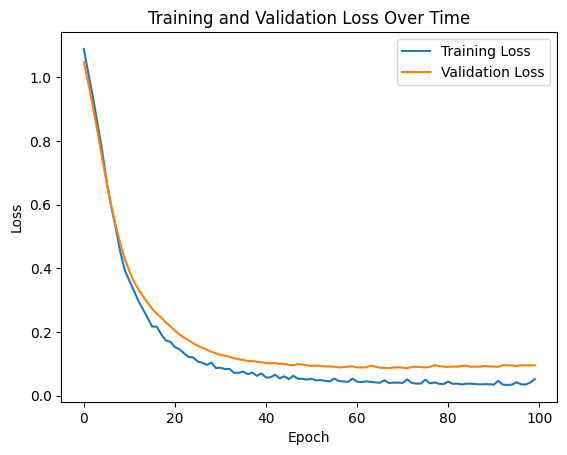

Test Accuracy: 0.9667
Confusion Matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



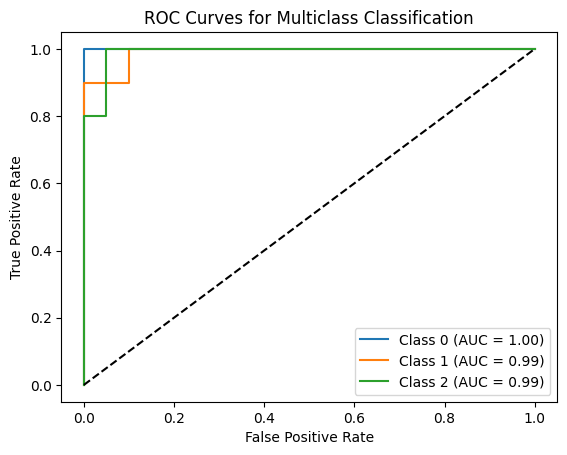

In [1]:
# Split the dataset into features (X) and target (y)
X = df.drop('species', axis=1).values  # Assuming 'species' is the target column
y = df['species'].values

# Encode the target variable (species) into numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the features to ensure all inputs to the neural network are on a similar scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the neural network model
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # Input size is 4 (features)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # Output size is 3 (classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = IrisNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model with validation monitoring
def train_model(model, train_loader, test_loader, epochs=100):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate validation loss
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for X_val, y_val in test_loader:
                val_outputs = model(X_val)
                val_loss += criterion(val_outputs, y_val).item()
            val_loss /= len(test_loader)

        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        model.train()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss:.4f}")
    return train_losses, val_losses

# Train the model for 100 epochs
train_losses, val_losses = train_model(model, train_loader, test_loader, epochs=100)

# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, dim=1).numpy()

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", class_report)

# ROC-AUC curve for each class (One-vs-Rest approach)
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_pred_proba = torch.softmax(y_pred, dim=1).numpy()

fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Plot ROC Curves
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


### ROC curve
-The AUC represents the area under each ROC curve. An AUC value closer to 1.00 indicates excellent model performance. Here, all the classes have AUCs close to 1, suggesting that the model is highly effective at distinguishing between the classes.

-The dashed diagonal line represents a random classifier

-The dashed diagonal line represents a random classifier. The closer a ROC curve is to the upper left corner (higher TPR, lower FPR), the better the model is at classifying correctly. If the ROC curve were close to this diagonal line, the model would be no better than random guessing.

- True Positive Rate:


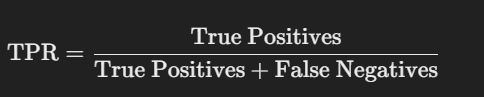

- false positive rate:

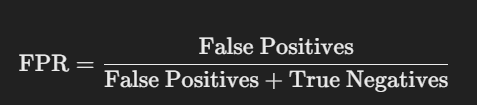

## Precision:
Precision measures how many of the instances predicted as positive are actually positive.

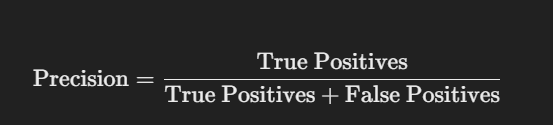

##  Recall
Recall measures how many of the actual positives were correctly classified by the model.
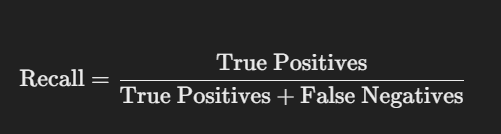

##F1-Score:
The F1-score gives a single score that represents the model’s accuracy in terms of both precision and recall.

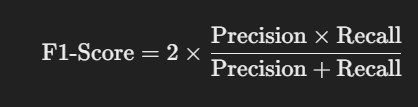
##Support

Support represents the number of actual occurrences of each class in the dataset.
